# Modeling Commonalities Among Banned Books in US Prisons in 18 States

Through this Jupyter notebook, I will be performing manipulations on data drawn from The Marshall Project, using topic modeling and data visualization to explore
commonalities among them. Please see the accompanying paper for methodology and discussion of the results.

In [1]:
### Imports

import numpy as np
import pandas as pd
import spacy
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models

nlp = spacy.load("en_core_web_sm")

/home/vivian/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
"""
Conveniently, the project provides a list of all the states' data combined. See the paper for discussion of some complications around this.
We pull the csv from the Marshall Project website, save it into a Pandas dataframe, and print it to make sure everything looks good.
We also save the original csv locally. This isn't necessary, but it's good practice to keep our original data at hand as it allows us to reference things more easily
going forward, particularly if the original link dies at some point.
"""
print("Pulling CSV into the dataframe, please wait!")
books_df = pd.read_csv("https://s3.amazonaws.com/tmp-gfx-public-data/banned-books20220819/banned_book_data_combined_lists.csv?a", encoding="utf-8")
books_df.to_csv("./banned_books.csv")
print("CSV loaded and saved locally! Here it is:")
books_df

Pulling CSV into the dataframe, please wait!
CSV loaded and saved locally! Here it is:


,publication,author,date,year,month,day,reason,state_arc
0,[ARABIC LANGUAGE CHARACTERS].,NaN,2019-12-18 00:00:00,2019.0,12.0,18.0,NaN,fl
1,[ARABIC LANGUAGE CHARACTERS]. TAJWEED QURAN.,NaN,2021-09-09 00:00:00,2021.0,9.0,9.0,NaN,fl
2,[KOREAN LANGUAGE CHARACTERS] HOLY SPIRIT LOVE.,NaN,2021-02-25 00:00:00,2021.0,2.0,25.0,NaN,fl
3,[KOREAN LANGUAGE CHARACTERS].,NaN,2021-02-25 00:00:00,2021.0,2.0,25.0,NaN,fl
4,[KOREAN LANGUAGE CHARACTERS].,NaN,2021-02-25 00:00:00,2021.0,2.0,25.0,NaN,fl
...,...,...,...,...,...,...,...,...
48371,Mentalism Companion,NaN,2021-08-25 00:00:00,2021.0,8.0,25.0,NaN,ri
48372,"You Can Read Anyone, Rules of the Game",NaN,2021-09-22 00:00:00,2021.0,9.0,22.0,NaN,ri
48373,Sex Slave never judge a Women by her desires,NaN,2021-09-30 00:00:00,2021.0,9.0,30.0,NaN,ri
48374,Moorish American Civics Guide,NaN,2021-09-30 00:00:00,2021.0,9.0,30.0,NaN,ri


In [3]:
# First, we clean the dataframe by removing the columns that aren't of interest to us: the time-related ones. Then we replace all NaN values with the string "None,"
# this allows us to properly process it with Spacy while still keeping track of how many nil values are present in the data.

books_df.drop("date", inplace=True, axis=1)
books_df.drop("year", inplace=True, axis=1)
books_df.drop("month", inplace=True, axis=1)
books_df.drop("day", inplace=True, axis=1)
books_df = books_df.fillna("None")
#books_df["author"]=books_df["author"].map(str)
# Then print again to see how it looks.

books_df

,publication,author,reason,state_arc
0,[ARABIC LANGUAGE CHARACTERS].,None,None,fl
1,[ARABIC LANGUAGE CHARACTERS]. TAJWEED QURAN.,None,None,fl
2,[KOREAN LANGUAGE CHARACTERS] HOLY SPIRIT LOVE.,None,None,fl
3,[KOREAN LANGUAGE CHARACTERS].,None,None,fl
4,[KOREAN LANGUAGE CHARACTERS].,None,None,fl
...,...,...,...,...
48371,Mentalism Companion,None,None,ri
48372,"You Can Read Anyone, Rules of the Game",None,None,ri
48373,Sex Slave never judge a Women by her desires,None,None,ri
48374,Moorish American Civics Guide,None,None,ri


In [4]:
# With itertuples we read each column of the dataframe into a separate variable to later process with Spacy. We also make a string list of the publication and reason columns to use for topic modeling later.

#publication_words = books_df['publication'].tolist()
#reason_words = books_df['reason'].tolist()

publication_column = (row.publication for row in books_df.itertuples())
author_column = (row.author for row in books_df.itertuples())
reason_column = (row.reason for row in books_df.itertuples())
state_column = (row.state_arc for row in books_df.itertuples())
#We return to these variables later when we do some topic modeling, but first we do POS tagging in Spacy.

In [5]:
# We move to Spacy and run through the nlp pipeline, removing stopwords and non-alpha characters from the publication and reason columns while we're at it.
# This gives us the Spacy data we will analyze. The publication_words and reason_words lists contain every alpha nonstop word in their respective columns and will be used for topic modeling later.

publication_nouns = []
publication_proper = []
publication_verbs = []
author_names = []
reason_nouns = []
states = []
publication_words = []
words_to_model = []

print("Running everything through the Spacy NLP pipeline. This may take some time, please be patient.")

# We process the publication column, pulling out alphanumeric, nonstop, lemmatized versions of the nouns, proper nouns, and verbs.
print("\nProcessing publication column.")
for doc in nlp.pipe(publication_column):
    for token in doc:
        if token.is_alpha and not token.is_stop:
            words_to_model.append(token.lemma_.lower())
            if token.pos_ == "NOUN":
                publication_nouns.append(token.lemma_.lower())
            elif token.pos_ == "PROPN":
                publication_proper.append(token.lemma_.lower())
            elif token.pos_ == "VERB":
                publication_verbs.append(token.lemma_.lower())
print("\n...\nPublication column processed.")

#We process the author column, just assembling one list of all the names.
print("\n...\nProcessing author column.")
for doc in nlp.pipe(author_column):
    for token in doc:
        if token.is_alpha:
            author_names.append(token.text.lower())
print("\n...\nAuthor column processed.")

#We process the reasons column, pulling out lemmatized nonstop nouns.
print("\n...\nProcessing reason column.")
for doc in nlp.pipe(reason_column):
    for token in doc:
        if token.is_alpha and not token.is_stop:
            words_to_model.append(token.lemma_.lower())
            if token.pos_ == "NOUN" or "PROPN":
                reason_nouns.append(token.lemma_.lower())
print("\n...\nReason column processed.")

#The states do not need to be sorted by POS since there's only one type of information in the column. However, to make sure our data is consistent we use Spacy
#to filter out any potential non-alpha characters.
print("\n...\nProcessing state column.")
for doc in nlp.pipe(state_column):
    for token in doc:
        if token.is_alpha:
            states.append(token.text.lower())


print("\n...\nState column processed.\n...\nAll columns have been processed, thank you for waiting.")

Running everything through the Spacy NLP pipeline. This may take some time, please be patient.

Processing publication column.

...
Publication column processed.

...
Processing author column.

...
Author column processed.

...
Processing reason column.

...
Reason column processed.

...
Processing state column.

...
State column processed.
...
All columns have been processed, thank you for waiting.


In [6]:
# Now we create Pandas series with our new lists of data, sorted by frequency, which we'll look at for our analysis.

publication_nouns_freq = pd.Series(publication_nouns, name="publication_nouns").value_counts()
publication_proper_freq = pd.Series(publication_proper, name="publication_proper").value_counts()
publication_verbs_freq = pd.Series(publication_verbs, name="publication_verbs").value_counts()
author_names_freq = pd.Series(author_names, name="author_names").value_counts()
reason_nouns_freq = pd.Series(reason_nouns, name="reason_nouns").value_counts()
states_freq = pd.Series(states, name="states").value_counts()

# Print truncated versions of each dataframe to make sure they look good.
print(publication_nouns_freq)
print(publication_proper_freq)
print(publication_verbs_freq)
print(author_names_freq)
print(reason_nouns_freq)
print(states_freq)

art            721
life           499
letter         414
book           392
issue          379
              ... 
moe              1
dogg             1
inglish          1
orca             1
anacarchism      1
Name: publication_nouns, Length: 5139, dtype: int64
vol             2265
book            1467
guide           1358
black           1019
edition          828
                ... 
stagg              1
metamorphose       1
ipulation          1
lollypops          1
revoultion         1
Name: publication_proper, Length: 13932, dtype: int64
penthouse     506
draw          303
illustrate    176
know          124
color         122
             ... 
imperfect       1
recover         1
pinstripe       1
xbox            1
reimage         1
Name: publication_verbs, Length: 1566, dtype: int64
none       32197
john         278
david        222
robert       216
michael      205
           ...  
anness         1
westra         1
enemig         1
smieth         1
bebby          1
Name: author_name

In [7]:
# Finally, we save all our cleaned, frequency-ordered lists to CSVs and proceed with our initial analysis.

print("Saving all frequency data to CSV.")
publication_nouns_freq.to_csv("./publication_nouns_freq.csv", encoding="utf-8")
publication_proper_freq.to_csv("./publication_proper_freq.csv", encoding="utf-8")
publication_verbs_freq.to_csv("./publications_proper_freq.csv", encoding="utf-8")
author_names_freq.to_csv("./author_names.csv", encoding="utf-8")
reason_nouns_freq.to_csv("./reason_nouns_freq", encoding="utf-8")
states_freq.to_csv("./states_freq.csv", encoding="utf-8")
print("\n...\nSave complete.")

Saving all frequency data to CSV.

...
Save complete.


In the following cells I've printed each freq dataframe fully so that the data can be analyzed without leaving Jupyter. See the bottom of the notebook for visualizations of the frequencies and topic model. [To skip to where we pick the original dataframes back up and perform some topic modeling, click here.](#topic_modeling)

[Publication Nouns Frequency](#pub_noun_freq)

<a id="pub_noun_freq"></a>

In [8]:
publication_nouns_freq

art            721
life           499
letter         414
book           392
issue          379
              ... 
moe              1
dogg             1
inglish          1
orca             1
anacarchism      1
Name: publication_nouns, Length: 5139, dtype: int64

In [9]:
publication_proper_freq

vol             2265
book            1467
guide           1358
black           1019
edition          828
                ... 
stagg              1
metamorphose       1
ipulation          1
lollypops          1
revoultion         1
Name: publication_proper, Length: 13932, dtype: int64

In [10]:
publication_verbs_freq

penthouse     506
draw          303
illustrate    176
know          124
color         122
             ... 
imperfect       1
recover         1
pinstripe       1
xbox            1
reimage         1
Name: publication_verbs, Length: 1566, dtype: int64

In [11]:
author_names_freq

none       32197
john         278
david        222
robert       216
michael      205
           ...  
anness         1
westra         1
enemig         1
smieth         1
bebby          1
Name: author_names, Length: 9562, dtype: int64

In [12]:
reason_nouns_freq

explicit        4895
sexually        4744
exclude         4632
image           3970
pgs             3493
                ... 
infer              1
depcits            1
penological        1
flammable          1
organization       1
Name: reason_nouns, Length: 1610, dtype: int64

In [13]:
states_freq

fl    20202
tx     9396
az     4632
va     2553
wi     2281
or     1780
ct     1659
sc     1509
ca     1424
mi      974
nc      600
ia      431
mt      374
nj      232
il      134
ks       99
ri       68
ga       28
Name: states, dtype: int64

In the following cells, we return to our publication and reason word lists and perform topic modeling on them to get some additional data.

In [14]:
# Satisfied with Spacy we now get another angle on our data by analyzing the publication and reason columns with gensim topic modeling.
# We use the list of words nonstop alpha words we collected from the publication and reason categories. These could be analyzed with two different topics, but as
# the reason and publication titles are quite related thematically, I felt analyzing them together made the most sense.
print("Processing word lists and creating dictionaries and corpora with gensim.")
words_text = [[text for text in doc.split()] for doc in words_to_model]
words_dict = corpora.Dictionary(words_text)
words_dict.filter_extremes(no_below=2, no_above=1.0)
words_corpus = [words_dict.doc2bow(doc, allow_update = True) for doc in words_text]

print("\n...\nProcessing complete!")

Processing word lists and creating dictionaries and corpora with gensim.

...
Processing complete!


In [15]:
# An LDA model is run on the data, counting 10 topics.
print("Creating topic model. This will take some time, please wait.")
lda_model = gensim.models.ldamodel.LdaModel(corpus=words_corpus,
                                            id2word=words_dict,
                                            num_topics=10,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
print("\n...\nModel complete.")

Creating topic model. This will take some time, please wait.

...
Model complete.


### Visualization

The rest of the cells are visualizations of the prior data. Selected graphs can also be seen in the paper.

In [25]:
# First we visualize the topic model data we just generated with pyLDAvis. We save the result as an html file.
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, words_corpus, words_dict, mds='mmds')
pyLDAvis.save_html(vis, 'publication_and_reasons_LDA_topic_model.html')
vis

/home/vivian/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/home/vivian/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/vivian/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/vivian/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/vivian/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWa

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.559236 -0.144950       1        1  96.006589
7     -0.008817 -0.210747       2        1   1.369267
5     -0.048280  0.186055       3        1   1.122001
2      0.082043  0.037871       4        1   0.602618
6      0.197897 -0.048618       5        1   0.393244
1      0.067289  0.036135       6        1   0.118778
8      0.067282  0.036084       7        1   0.118036
0      0.067269  0.036039       8        1   0.103262
9      0.067276  0.036066       9        1   0.084781
3      0.067276  0.036065      10        1   0.081425, topic_info=            Term          Freq         Total Category  logprob  loglift
54           sex   1673.000000   1673.000000  Default  30.0000  30.0000
34          book   1137.000000   1137.000000  Default  29.0000  29.0000
63        tattoo    340.000000    340.000000  Default  28.0000  28.0000
6422    sexually  25017.000000  25017.000000  Default  27.0000  27.0000
1901    explicit  24746.000000  24746.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
24           men      0.010031      0.408646  Topic10  -9.7658   3.4061
25        health      0.010031      0.413216  Topic10  -9.7658   3.3950
26           bad      0.010031      0.408547  Topic10  -9.7658   3.4064
27    psychopath      0.010031      0.408497  Topic10  -9.7658   3.4065
29       killers      0.010031      0.408628  Topic10  -9.7658   3.4062

[825 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
437       1  0.999563  activity
1349      1  0.999571       age
9098      1  0.998443       alc
78        2  0.886124       art
5667      1  0.992564     blank
...     ...       ...       ...
410       1  0.997304       use
2142      1  0.999843         w
930       1  0.995029       war
581       1  0.997604     write
2361      1  0.997375   writing

[75 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 6, 3, 7, 2, 9, 1, 10, 4])

In [18]:
# Next we visualize the frequency data we found with Spacy using matplotlib.
# We set up variables that index the first 0 items from the nouns, verbs, author, and proper nouns variables.
# We don't index the states so we can see every state visualized.

Publication_Nouns_Plot = publication_nouns_freq[0:50]
Publication_Verbs_Plot = publication_verbs_freq[0:50]
Publication_Propn_Plot = publication_proper_freq[0:50]
#We index author names 1:51 because through experimentation I found that the None category is so much larger than any other, it makes the graph unreadable.
Author_Names_Plot = author_names_freq[1:51]
Reason_Nouns_Plot = reason_nouns_freq[0:50]
States_Plot = states_freq

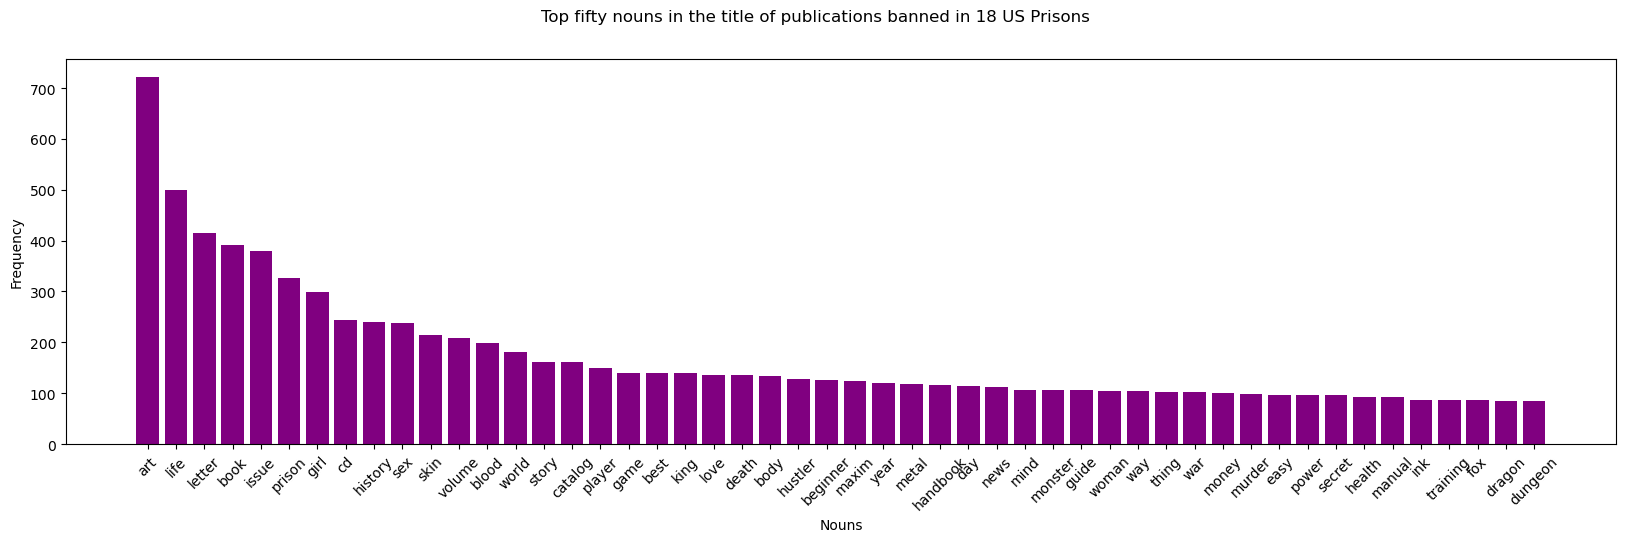

In [19]:
# We go through each variable to be plotted and visualize them one by one.

plt.figure(figsize = (20, 5))
plt.bar(Publication_Nouns_Plot.index, Publication_Nouns_Plot.tolist(), color="purple")
plt.xlabel("Nouns")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.suptitle("Top fifty nouns in the title of publications banned in 18 US Prisons")
plt.savefig("./publication_nouns_graph.png", dpi=200)
plt.show()

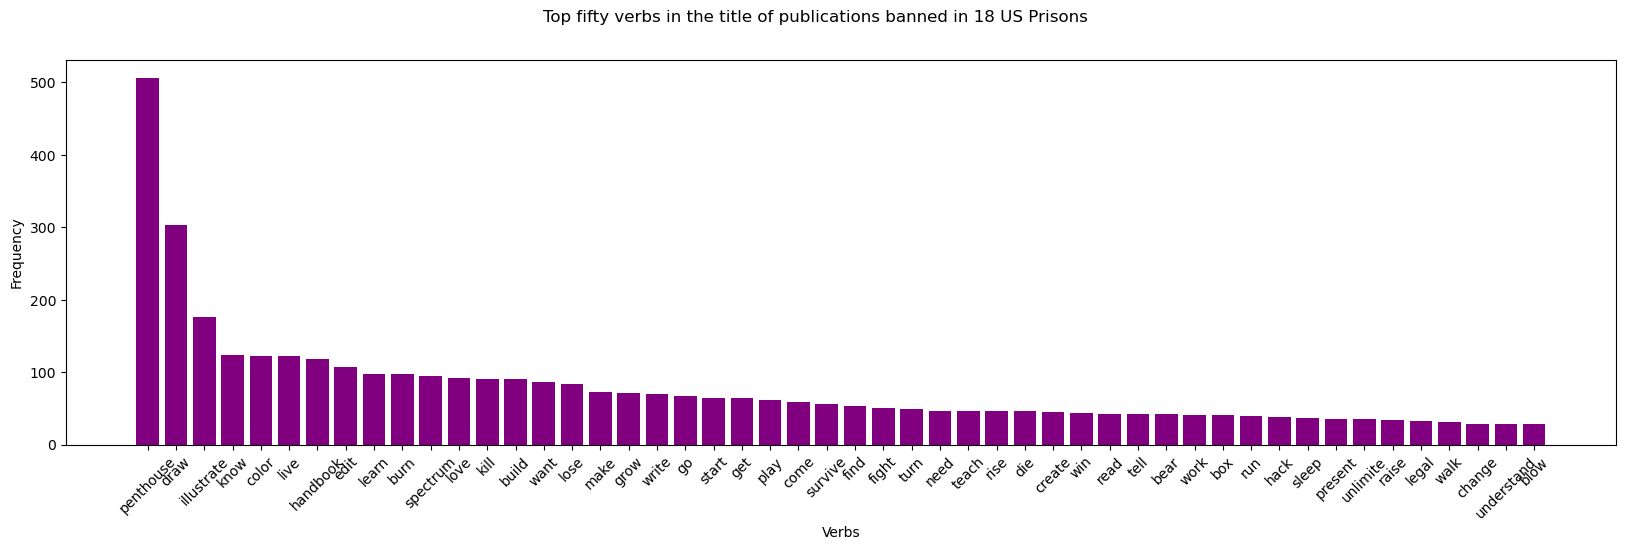

In [20]:
plt.figure(figsize=(20, 5))
plt.bar(Publication_Verbs_Plot.index, Publication_Verbs_Plot.tolist(), color="purple")
plt.xlabel("Verbs")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.suptitle("Top fifty verbs in the title of publications banned in 18 US Prisons")
plt.savefig("./publication_verbs_graph.png", dpi=200)
plt.show()

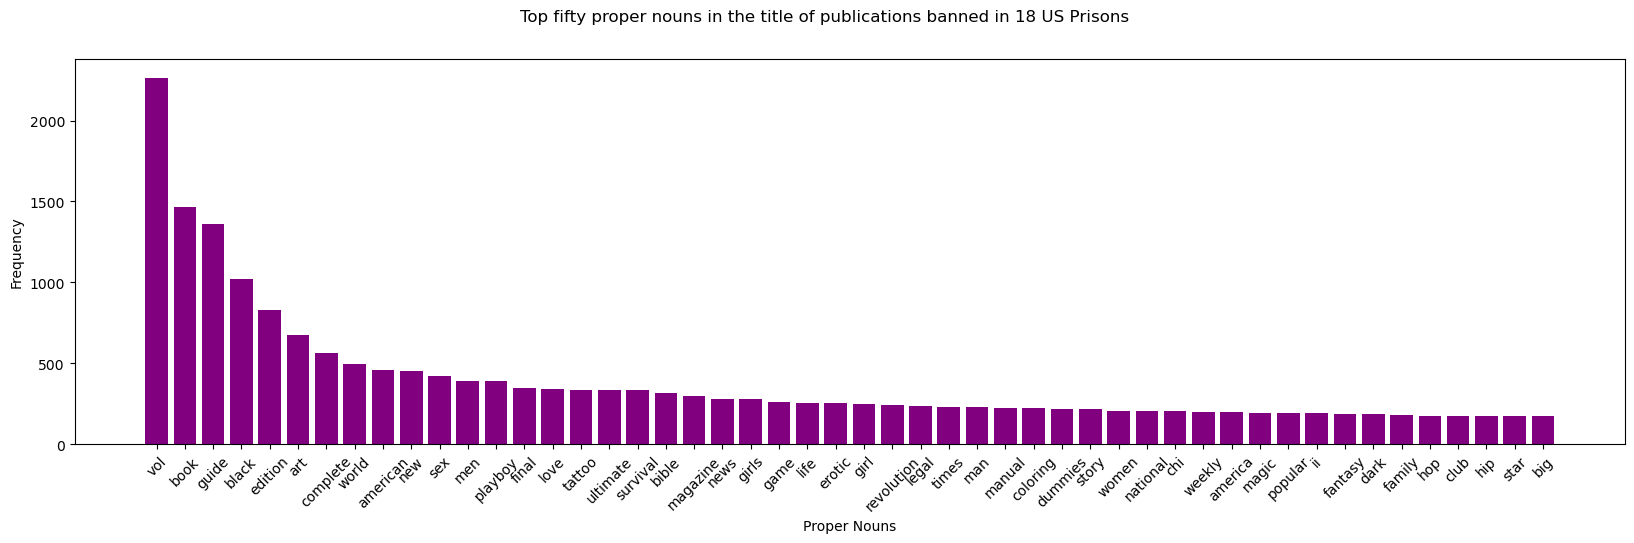

In [21]:
plt.figure(figsize=(20, 5))
plt.bar(Publication_Propn_Plot.index, Publication_Propn_Plot.tolist(), color="purple")
plt.xlabel("Proper Nouns")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.suptitle("Top fifty proper nouns in the title of publications banned in 18 US Prisons")
plt.savefig("./publication_proper_nouns_graph.png", dpi=200)
plt.show()

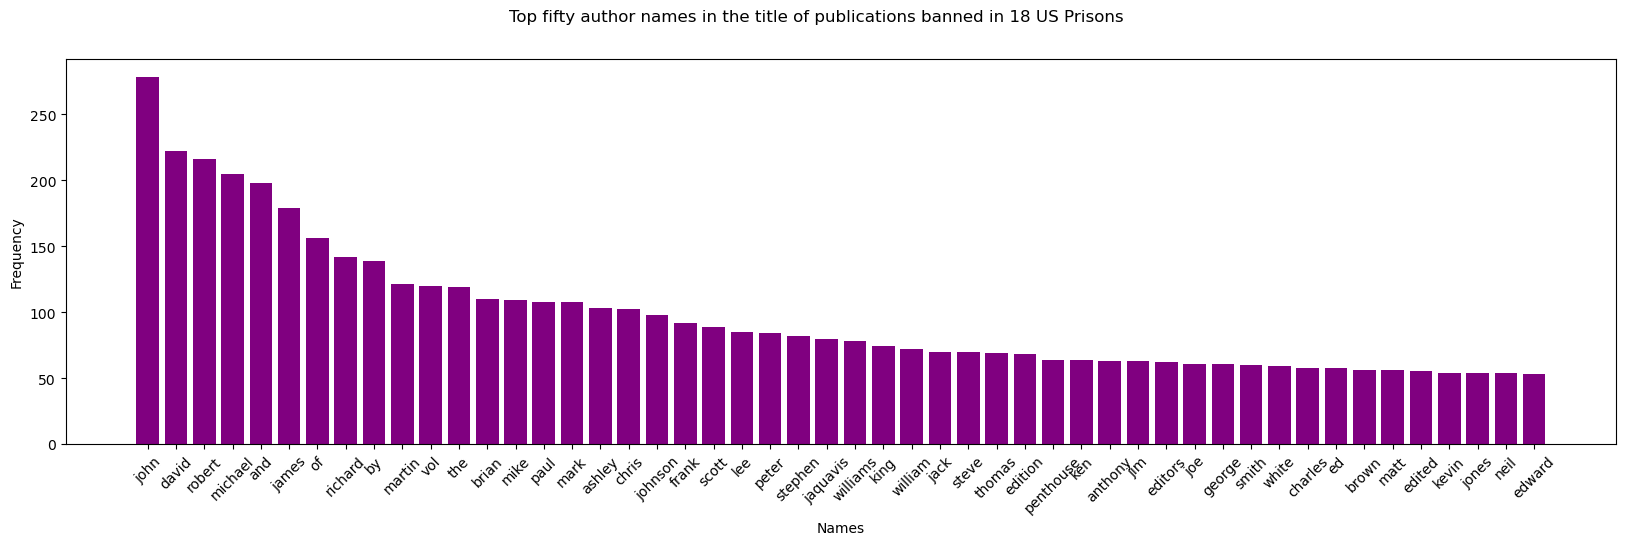

In [22]:
plt.figure(figsize=(20, 5))
plt.bar(Author_Names_Plot.index, Author_Names_Plot.tolist(), color="purple")
plt.xlabel("Names")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.suptitle("Top fifty author names in the title of publications banned in 18 US Prisons")
plt.savefig("./author_names_graph.png", dpi=200)
plt.show()

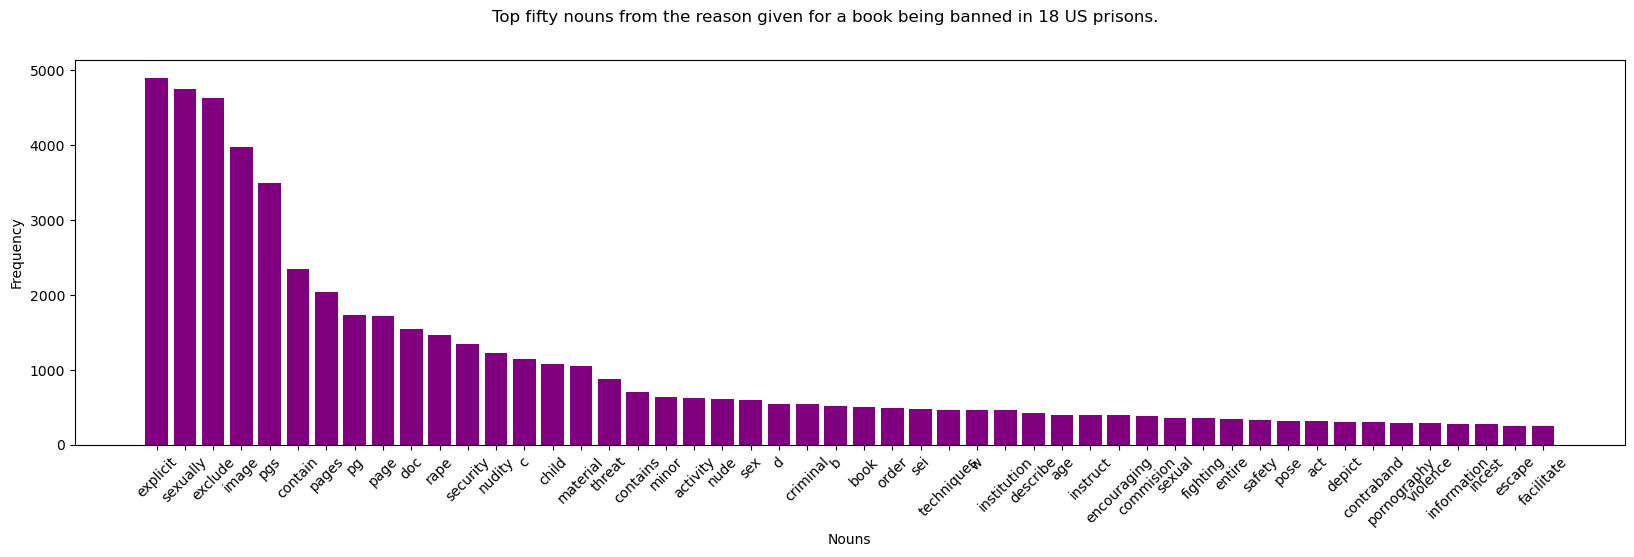

In [23]:
plt.figure(figsize=(20, 5))
plt.bar(Reason_Nouns_Plot.index, Reason_Nouns_Plot.tolist(), color="purple")
plt.xlabel("Nouns")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.suptitle("Top fifty nouns from the reason given for a book being banned in 18 US prisons.")
plt.savefig("./reason_nouns_graph.png", dpi=200)
plt.show()

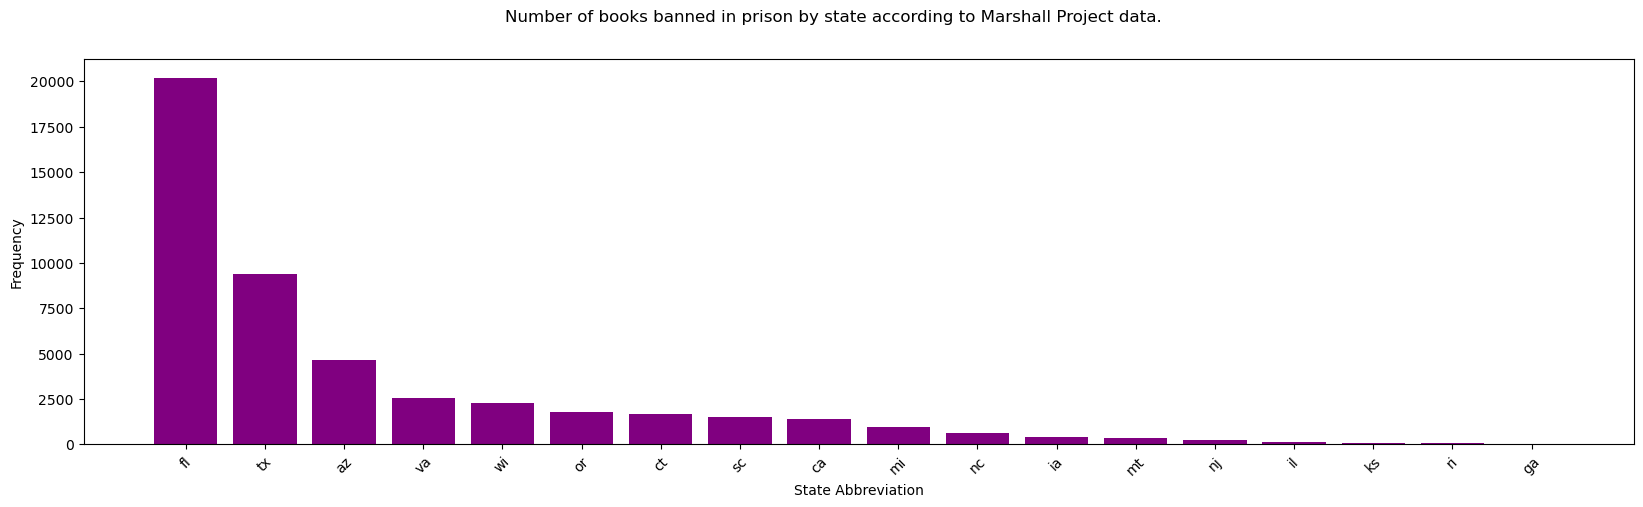

In [24]:
plt.figure(figsize=(20, 5))
plt.bar(States_Plot.index, States_Plot.tolist(), color="purple")
plt.xlabel("State Abbreviation")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.suptitle("Number of books banned in prison by state according to Marshall Project data.")
plt.savefig("./states_graph.png", dpi=200)
plt.show()